In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
import copy

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = (28, 28, 1)

In [3]:
def create_train_test_buckets(x_train, y_train, x_test, y_test):
    '''
    
    '''
    partitioned_train_arrays = {}
    numpy_partitioned_train_arrays = {}

    train_mix_fraction = 0.2
    test_mix_fraction = 0.2

    train_mix_length = int(len(x_train)*train_mix_fraction)
    test_mix_length = int(len(x_test)*test_mix_fraction)

    for item in zip(x_train,y_train):
        partitioned_train_arrays[item[1]]=([],[])

    for item in zip(x_train[:train_mix_length],y_train[:train_mix_length]):
        partitioned_train_arrays[item[1]][0].append(item[0])
        partitioned_train_arrays[item[1]][1].append(item[1])

    for item in zip(x_train[train_mix_length:],y_train[train_mix_length:]):
        random_bucket = int(np.random.randint(0,10,1))
        partitioned_train_arrays[random_bucket][0].append(item[0])
        partitioned_train_arrays[random_bucket][1].append(item[1])

    for item in partitioned_train_arrays:
        numpy_partitioned_train_arrays[item] = (np.array(partitioned_train_arrays[item][0]), np.array(partitioned_train_arrays[item][1]))

        
    partitioned_test_arrays = {}
    numpy_partitioned_test_arrays = {}


    for item in zip(x_test,y_test):
        partitioned_test_arrays[item[1]]=([],[])

    for item in zip(x_test[:test_mix_length],y_test[:test_mix_length]):
        partitioned_test_arrays[item[1]][0].append(item[0])
        partitioned_test_arrays[item[1]][1].append(item[1])

    for item in zip(x_test[test_mix_length:],y_test[test_mix_length:]):
        random_bucket = int(np.random.randint(0,10))
        partitioned_test_arrays[random_bucket][0].append(item[0])
        partitioned_test_arrays[random_bucket][1].append(item[1])


    for item in partitioned_test_arrays:
        partitioned_test_arrays[item] = (np.array(partitioned_test_arrays[item][0]), np.array(partitioned_test_arrays[item][1]))

    return(numpy_partitioned_train_arrays, partitioned_test_arrays)

In [4]:
partitioned_train_arrays, partitioned_test_arrays = create_train_test_buckets(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


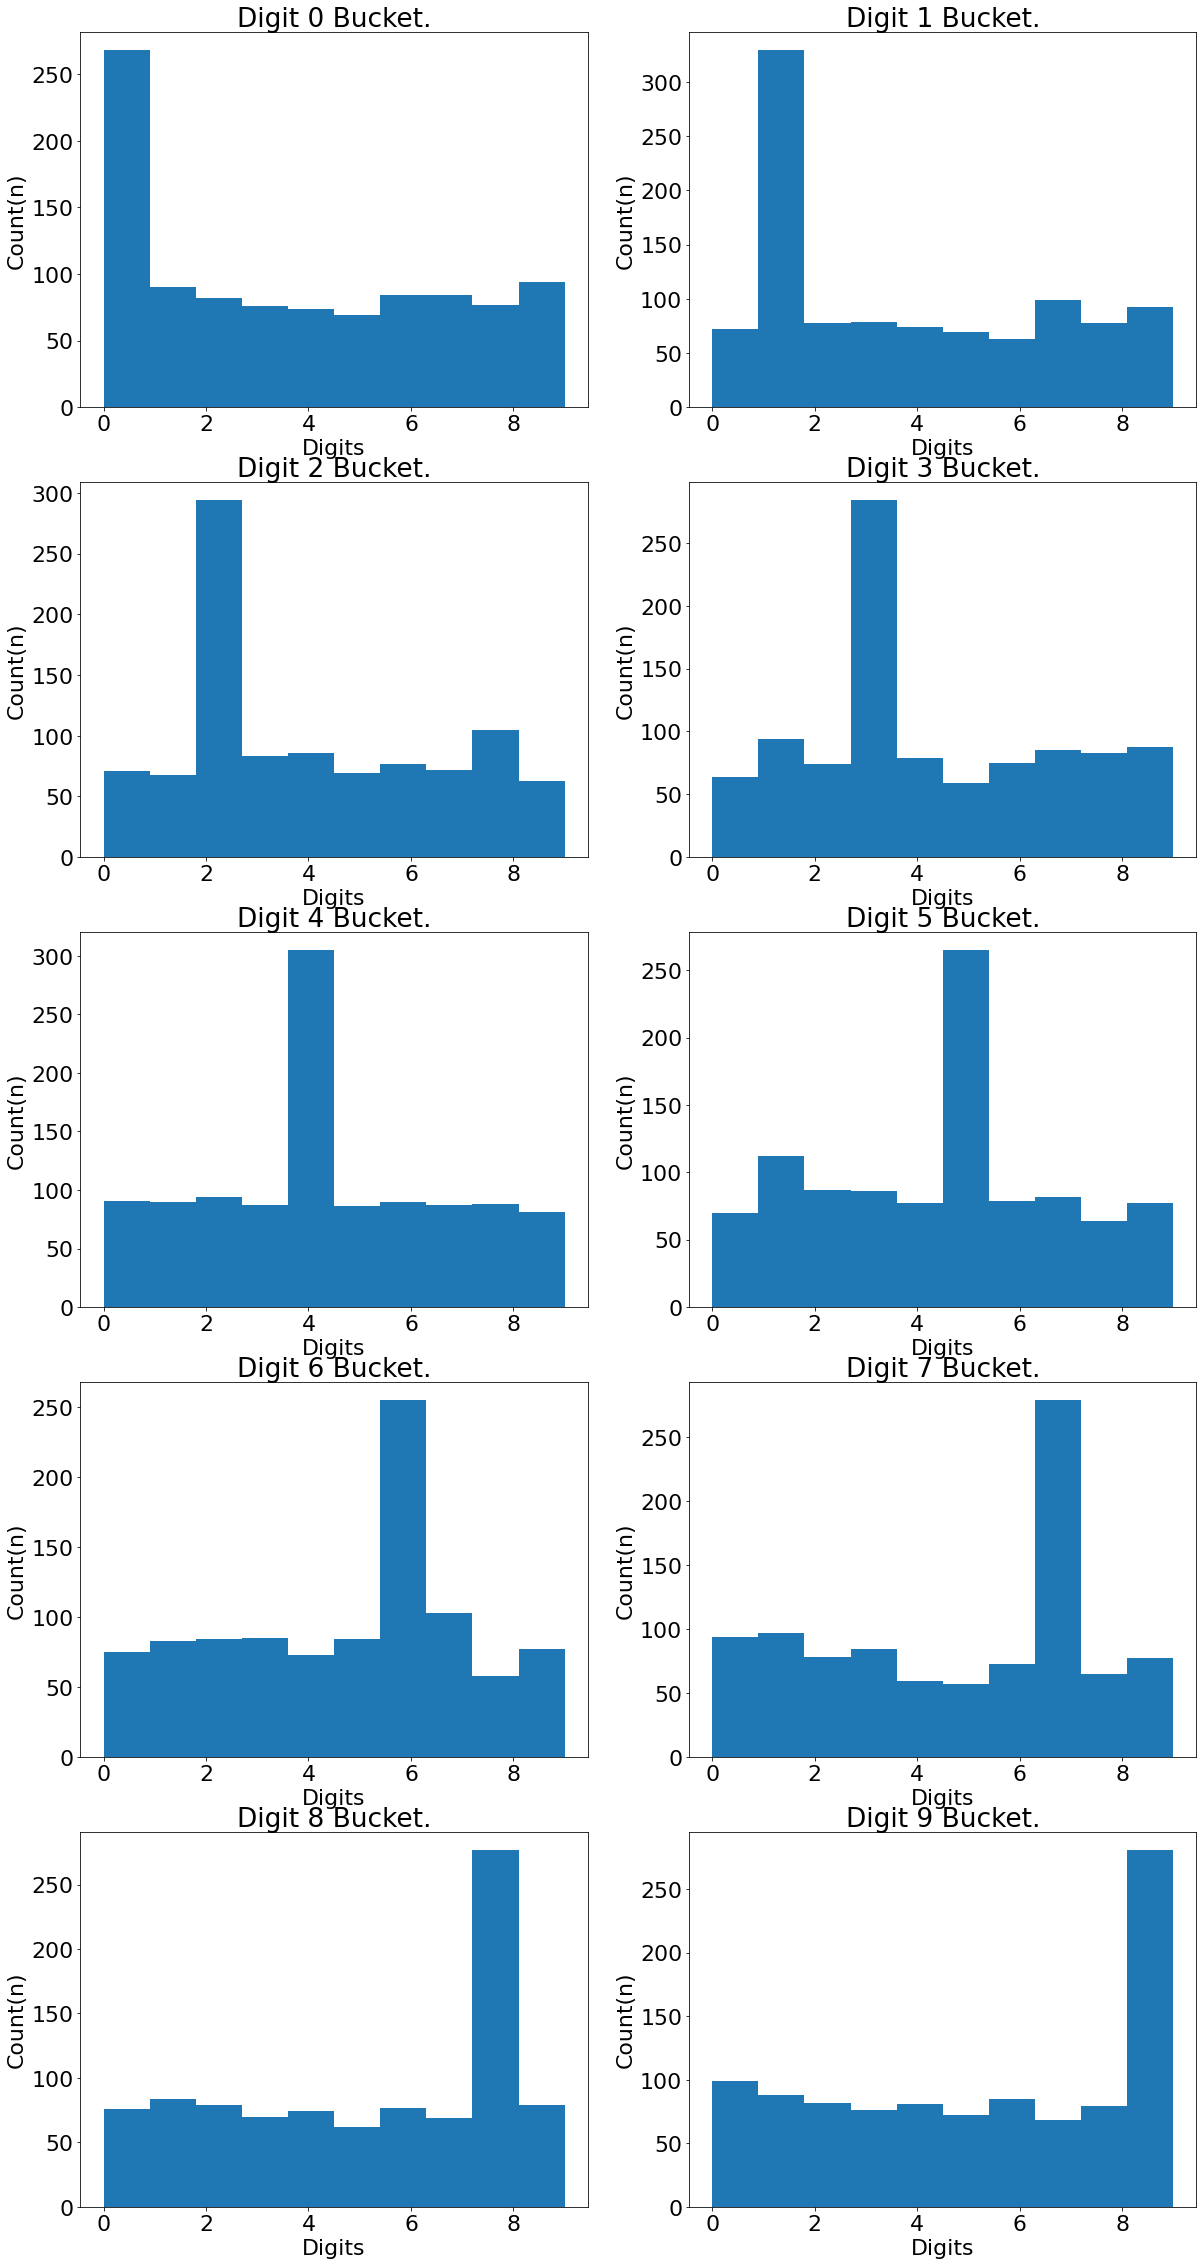

In [5]:
fig1, axs = plt.subplots(5,2, figsize=(20,40))
for row in range(5):
    for col in range(2):
        axs[row, col].hist(partitioned_test_arrays[row*2+col][1])
        axs[row, col].set_title('Digit {} Bucket.'.format(row*2+col))
        axs[row, col].set(xlabel='Digits', ylabel='Count(n)')

In [6]:
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(28, kernel_size=(5,5),input_shape=input_shape),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(14, kernel_size=(5,5)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(84,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

'numpy_partitioned_train_arrays' is dictionary with 10 keys corresponding to 0,1, ..., 9 digits.

In [7]:
def local_train(model, model_index, partitioned_train_arrays, partitioned_test_arrays, x_test, y_test, train_sample_count=100):
    x_train_reshaped = partitioned_train_arrays[model_index][0].reshape(-1,28,28,1)
    y_train_reshaped = partitioned_train_arrays[model_index][1]

    random_rows = np.random.choice(x_train_reshaped.shape[0], train_sample_count, replace=False)

    x_train_partitioned = x_train_reshaped[random_rows,:]
    y_train_partitioned = y_train_reshaped[random_rows]
    model.fit(x=x_train_partitioned, y=y_train_partitioned, epochs=1)
    
    x_test_partitioned = partitioned_test_arrays[model_index][0].reshape(-1,28,28,1)
    y_test_partitioned = partitioned_test_arrays[model_index][1]
    
    train_accuracy = model.evaluate(x_train_partitioned, y_train_partitioned)
    local_test_acciracy = model.evaluate(x_test_partitioned.reshape(-1,28,28,1), y_test_partitioned)
    global_test_accuracy = model.evaluate(x_test.reshape(-1,28,28,1), y_test)
    
    print('Accuracies: Training={}, Local Test={}, Global Test={}'.format(train_accuracy[1], local_test_acciracy[1], global_test_accuracy[1]))
    return(model, train_accuracy, local_test_acciracy, global_test_accuracy)
    

In [8]:
def average_models_weights(models_collection):
    '''
    '''
    
    weights = [models_collection[model].get_weights() for model in models_collection]

    new_weights = copy.copy(np.array(weights).mean(axis=0, out=None))

    new_model = create_keras_model()
#     new_model.compile(optimizer='adam',
#                       loss='sparse_categorical_crossentropy',
#                       metrics=['accuracy'])
    new_model.set_weights(new_weights)
    
    return(new_model)

## Regular Training (Non-Federated)

In [ ]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
experiment_prefix = 'regular_'
for item in range(10):
    models_collection['model_{}'.format(item)] = 0
    tf.keras.models.save_model(model=model_global, filepath='{}model_{}'.format(experiment_prefix,item))
    
training_round = 25
training_round_accuracies_regular = []
train_sample_count=100
for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in models_collection:
        current_model = tf.keras.models.load_model(experiment_prefix+model)
        #models_collection[model].compile(optimizer='adam',
        #    loss='sparse_categorical_crossentropy',
        #    metrics=['accuracy'])
        results = local_train(model=current_model,
                        model_index=int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        #print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        #print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        #models_collection[model] = tf.keras.models.clone_model(results[0])
        tf.keras.models.save_model(results[0], filepath=experiment_prefix+model)
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_regular.append(models_accuracies)

    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
INFO:tensorflow:Assets written to: regular_model_0/assets
INFO:tensorflow:Assets written to: regular_model_1/assets
INFO:tensorflow:Assets written to: regular_model_2/assets
INFO:tensorflow:Assets written to: regular_model_3/assets
INFO:tensorflow:Assets written to: regular_model_4/assets
INFO:tensorflow:Assets written to: regular_model_5/assets
INFO:tensorflow:Assets written to: regular_model_6/assets
INFO:tensorflow:Assets written to: regular_model_7/assets
INFO:tensorflow:Assets written to: regular_model_8/assets
INFO:tensorflow:Assets written to: regular_model_9/assets
Starting iteration: 0
313/313 [==============================] - 2s 7ms/step - loss: 14.4027 - accuracy: 0.2206
Accuracies: Training=0.38999998569488525, Local Test=0.34669339656829834, Global Test=0.22059999406337738
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 8ms/step - loss: 11.9246 - accuracy: 0.2404
Accuracies: Training=0.430000

INFO:tensorflow:Assets written to: regular_model_4/assets
313/313 [==============================] - 4s 13ms/step - loss: 10.8189 - accuracy: 0.2876
Accuracies: Training=0.3100000023841858, Local Test=0.32832834124565125, Global Test=0.28760001063346863
INFO:tensorflow:Assets written to: regular_model_5/assets
313/313 [==============================] - 5s 15ms/step - loss: 8.9879 - accuracy: 0.2845 0s - loss: 8.9829 - accuracy
Accuracies: Training=0.5400000214576721, Local Test=0.3889457583427429, Global Test=0.28450000286102295
INFO:tensorflow:Assets written to: regular_model_6/assets
313/313 [==============================] - 3s 9ms/step - loss: 8.0659 - accuracy: 0.3126
Accuracies: Training=0.4300000071525574, Local Test=0.3852544128894806, Global Test=0.3125999867916107
INFO:tensorflow:Assets written to: regular_model_7/assets
313/313 [==============================] - 5s 17ms/step - loss: 8.8129 - accuracy: 0.2669
Accuracies: Training=0.3799999952316284, Local Test=0.2903907001018

Accuracies: Training=0.5600000023841858, Local Test=0.48296594619750977, Global Test=0.3709999918937683
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 5s 16ms/step - loss: 7.0652 - accuracy: 0.3998
Accuracies: Training=0.6200000047683716, Local Test=0.5140367746353149, Global Test=0.39980000257492065
INFO:tensorflow:Assets written to: regular_model_1/assets
313/313 [==============================] - 2s 8ms/step - loss: 4.9794 - accuracy: 0.4211
Accuracies: Training=0.6399999856948853, Local Test=0.420040488243103, Global Test=0.421099990606308
INFO:tensorflow:Assets written to: regular_model_2/assets
313/313 [==============================] - 3s 10ms/step - loss: 8.1912 - accuracy: 0.3493
Accuracies: Training=0.4699999988079071, Local Test=0.46192893385887146, Global Test=0.34929999709129333
INFO:tensorflow:Assets written to: regular_model_3/assets
313/313 [==============================] - 3s 11ms/step - loss: 5.9888 - accuracy: 0.

313/313 [==============================] - 3s 11ms/step - loss: 4.2467 - accuracy: 0.4870
Accuracies: Training=0.6299999952316284, Local Test=0.5230296850204468, Global Test=0.4869999885559082
INFO:tensorflow:Assets written to: regular_model_6/assets
313/313 [==============================] - 3s 9ms/step - loss: 7.3841 - accuracy: 0.3321
Accuracies: Training=0.6700000166893005, Local Test=0.4392523467540741, Global Test=0.3321000039577484
INFO:tensorflow:Assets written to: regular_model_7/assets
313/313 [==============================] - 4s 12ms/step - loss: 4.9545 - accuracy: 0.4481
Accuracies: Training=0.6899999976158142, Local Test=0.4920802414417267, Global Test=0.4481000006198883
INFO:tensorflow:Assets written to: regular_model_8/assets
313/313 [==============================] - 3s 9ms/step - loss: 5.4434 - accuracy: 0.4213
Accuracies: Training=0.6399999856948853, Local Test=0.5093966126441956, Global Test=0.4212999939918518
INFO:tensorflow:Assets written to: regular_model_9/asset

313/313 [==============================] - 3s 8ms/step - loss: 3.4045 - accuracy: 0.5117
Accuracies: Training=0.6399999856948853, Local Test=0.5819838047027588, Global Test=0.5116999745368958
INFO:tensorflow:Assets written to: regular_model_2/assets
313/313 [==============================] - 3s 8ms/step - loss: 5.0600 - accuracy: 0.3940
Accuracies: Training=0.5799999833106995, Local Test=0.3918781578540802, Global Test=0.39399999380111694
INFO:tensorflow:Assets written to: regular_model_3/assets
313/313 [==============================] - 3s 9ms/step - loss: 4.6904 - accuracy: 0.4344
Accuracies: Training=0.5799999833106995, Local Test=0.5059144496917725, Global Test=0.4343999922275543
INFO:tensorflow:Assets written to: regular_model_4/assets
313/313 [==============================] - 4s 11ms/step - loss: 3.6133 - accuracy: 0.4414
Accuracies: Training=0.5799999833106995, Local Test=0.46046045422554016, Global Test=0.4413999915122986
INFO:tensorflow:Assets written to: regular_model_5/asse

313/313 [==============================] - 3s 10ms/step - loss: 4.4746 - accuracy: 0.4375
Accuracies: Training=0.6899999976158142, Local Test=0.5290390849113464, Global Test=0.4375
INFO:tensorflow:Assets written to: regular_model_8/assets
313/313 [==============================] - 3s 10ms/step - loss: 4.0351 - accuracy: 0.4719
Accuracies: Training=0.6000000238418579, Local Test=0.5311572551727295, Global Test=0.47189998626708984
INFO:tensorflow:Assets written to: regular_model_9/assets
Finieshed iteration: 7
Starting iteration: 8
313/313 [==============================] - 3s 11ms/step - loss: 4.2121 - accuracy: 0.4974
Accuracies: Training=0.6499999761581421, Local Test=0.5841683149337769, Global Test=0.4973999857902527
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 3s 9ms/step - loss: 3.5070 - accuracy: 0.5129
Accuracies: Training=0.7300000190734863, Local Test=0.6214907765388489, Global Test=0.5128999948501587
INFO:tensorflow:Asset

313/313 [==============================] - 2s 8ms/step - loss: 3.5768 - accuracy: 0.5397
Accuracies: Training=0.7200000286102295, Local Test=0.6287534236907959, Global Test=0.5396999716758728
INFO:tensorflow:Assets written to: regular_model_4/assets
313/313 [==============================] - 3s 10ms/step - loss: 2.9051 - accuracy: 0.5215
Accuracies: Training=0.6800000071525574, Local Test=0.6036036014556885, Global Test=0.5214999914169312
INFO:tensorflow:Assets written to: regular_model_5/assets
313/313 [==============================] - 2s 8ms/step - loss: 3.0666 - accuracy: 0.5578
Accuracies: Training=0.7099999785423279, Local Test=0.6223132014274597, Global Test=0.5577999949455261
INFO:tensorflow:Assets written to: regular_model_6/assets
313/313 [==============================] - 3s 9ms/step - loss: 3.5581 - accuracy: 0.4879
Accuracies: Training=0.6700000166893005, Local Test=0.5628244876861572, Global Test=0.4878999888896942
INFO:tensorflow:Assets written to: regular_model_7/assets

199/313 [==================>...........] - ETA: 7:21 - loss: 2.5165 - accuracy: 0.5316 - ETA: 10:02 - loss: 2.6165 - accuracy: 0.520 - ETA: 9:59 - loss: 2.6137 - accuracy: 0.520 - ETA: 9:56 - loss: 2.6156 - accuracy: 0. - ETA: 9:54 - loss: 2.6228 - accuracy: 0.51 - ETA: 9:52 - loss: 2.6262 - accuracy: 0.51 - ETA: 9:54 - loss: 2.6225 - accuracy: 0.51 - ETA: 9:50 - loss: 2.6209 - accuracy: 0.51 - ETA: 9:45 - loss: 2.6120 - accuracy:  - ETA: 9:34 - loss: 2.6020 - accuracy: 0.52 - ETA: 9:31 - loss: 2.5941 - accuracy: 0.52 - ETA: 9:30 - loss: 2.5846 - accuracy - ETA: 9:14 - loss: 2.5732 - accuracy:  - ETA: 9:02 - loss: 2.5632 - accuracy: 0.52 - ETA: 8:59 - loss: 2.5531 - accuracy: 0.52 - ETA: 8:55 - loss: 2.5483 - accura - ETA: 8:37 - loss: 2.5528 - accuracy: 0.52 - ETA: 8:34 - loss: 2.5581 - accuracy: 0.52 - ETA: 8:31 - loss: 2.5524 - accuracy: 0.52 - ETA: 8:29 - loss: 2.5476 - accuracy: 0.52 - ETA: 8:25 - loss: 2.5413 - accuracy: 0. - ETA: 8:18 - loss: 2.5287 - accuracy: 0.52 - ETA: 8:14 

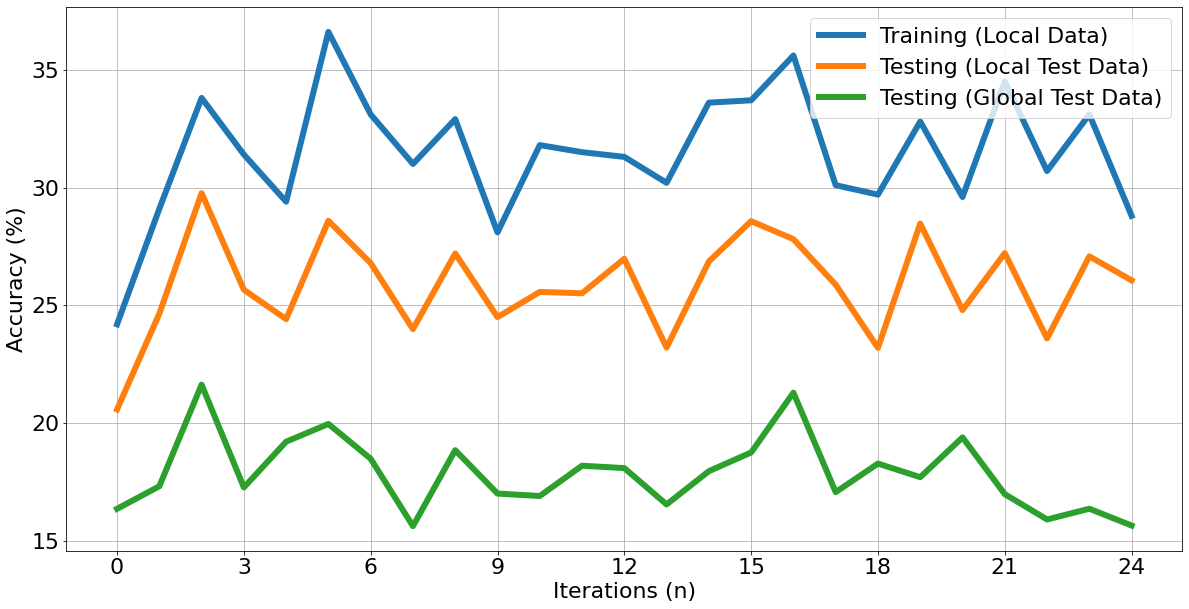

In [10]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_regular).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))



## Federated Learning

In [11]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
for item in range(10):
    models_collection['model_{}'.format(item)] = copy.copy(model_global)


training_round = 25
training_round_accuracies_federated_learning = []
train_sample_count=1000
for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in models_collection:
        models_collection[model].compile(optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])
        results = local_train(model=models_collection[model],
                        model_index=int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        
        '''
        Exteremely important to use "tf.keras.models.clone_model(results[0])" in the next
        line. Even copy.copy(results[0]) would produce a referenced model with the same weights/
        ''' 
        print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        models_collection[model] = tf.keras.models.clone_model(results[0])
        print('Model {} updated!'.format(model))
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_federated_learning.append(models_accuracies)
    print('Averaging Models')
    

    model_global = copy.copy(average_models_weights(models_collection))
    print('total model layers', np.shape(model_global.layers))

    models_collection = {}
    for item in range(10):
        models_collection['model_{}'.format(item)] = copy.copy(model_global)
    print('Model Memory IDs: {}, {}'.format(id(models_collection['model_0']),id(models_collection['model_1'])))
    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
Starting iteration: 0
313/313 [==============================] - 2s 7ms/step - loss: 21.6784 - accuracy: 0.1320
Accuracies: Training=0.11999999731779099, Local Test=0.11640211939811707, Global Test=0.13199999928474426
model_0 -0.063851476
model_0 -0.063851476
Model model_0 updated!
313/313 [==============================] - 2s 7ms/step - loss: 19.7038 - accuracy: 0.1246
Accuracies: Training=0.2800000011920929, Local Test=0.1547064334154129, Global Test=0.12460000067949295
model_1 0.052072406
model_1 -0.06285147
Model model_1 updated!
313/313 [==============================] - 2s 6ms/step - loss: 21.8379 - accuracy: 0.1238
Accuracies: Training=0.36000001430511475, Local Test=0.16347123682498932, Global Test=0.12380000203847885
model_2 0.052072406
model_2 -0.06166799
Model model_2 updated!
313/313 [==============================] - 2s 6ms/step - loss: 18.3964 - accuracy: 0.1202
Accuracies: Training=0.3199999928474426, Local Test=0.21227364242076874, Global Test=0

313/313 [==============================] - 2s 6ms/step - loss: 2.1471 - accuracy: 0.2541
Accuracies: Training=0.4399999976158142, Local Test=0.1979166716337204, Global Test=0.2540999948978424
model_5 0.0635277
model_5 -0.0716313
Model model_5 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.1009 - accuracy: 0.1749
Accuracies: Training=0.2800000011920929, Local Test=0.17471736669540405, Global Test=0.17489999532699585
model_6 0.0635277
model_6 -0.0716313
Model model_6 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.0313 - accuracy: 0.4155
Accuracies: Training=0.47999998927116394, Local Test=0.43232718110084534, Global Test=0.4154999852180481
model_7 0.0635277
model_7 -0.0716313
Model model_7 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.9250 - accuracy: 0.4934
Accuracies: Training=0.7599999904632568, Local Test=0.47041985392570496, Global Test=0.4934000074863434
model_8 0.0635277
model_8 -0.0716313
Model mode

Model model_0 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2995 - accuracy: 0.1744
Accuracies: Training=0.4399999976158142, Local Test=0.31220877170562744, Global Test=0.17440000176429749
model_1 0.08084062
model_1 0.015405416
Model model_1 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2879 - accuracy: 0.1701
Accuracies: Training=0.4000000059604645, Local Test=0.1755802184343338, Global Test=0.17010000348091125
model_2 0.08084062
model_2 -0.080554
Model model_2 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2502 - accuracy: 0.2304
Accuracies: Training=0.36000001430511475, Local Test=0.34909456968307495, Global Test=0.2303999960422516
model_3 0.08084062
model_3 -0.080554
Model model_3 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2184 - accuracy: 0.3179
Accuracies: Training=0.5199999809265137, Local Test=0.3963963985443115, Global Test=0.31790000200271606
model_4 0.08084062
mo

Model model_6 updated!
313/313 [==============================] - 2s 8ms/step - loss: 2.1618 - accuracy: 0.2773
Accuracies: Training=0.5600000023841858, Local Test=0.40603700280189514, Global Test=0.27730000019073486
model_7 0.050613016
model_7 0.0062021837
Model model_7 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.9743 - accuracy: 0.5139
Accuracies: Training=0.47999998927116394, Local Test=0.45324426889419556, Global Test=0.5138999819755554
model_8 0.050613016
model_8 0.0062021837
Model model_8 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.8866 - accuracy: 0.3713
Accuracies: Training=0.6000000238418579, Local Test=0.49292927980422974, Global Test=0.37130001187324524
model_9 0.050613016
model_9 0.0062021837
Model model_9 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 140278587306840, 140278586849096
Finieshed iteration: 4
Starting iteration: 5
313/313 [==============================] - 3s 9ms/step - loss: 2.

313/313 [==============================] - 2s 7ms/step - loss: 2.2400 - accuracy: 0.1281
Accuracies: Training=0.23999999463558197, Local Test=0.32996973395347595, Global Test=0.12809999287128448
model_2 -0.06932446
model_2 0.03998965
Model model_2 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1952 - accuracy: 0.2673
Accuracies: Training=0.4000000059604645, Local Test=0.23943662643432617, Global Test=0.267300009727478
model_3 -0.06932446
model_3 0.03998965
Model model_3 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1408 - accuracy: 0.2080
Accuracies: Training=0.4000000059604645, Local Test=0.37037035822868347, Global Test=0.20800000429153442
model_4 -0.06932446
model_4 0.03998965
Model model_4 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.1390 - accuracy: 0.4421
Accuracies: Training=0.5199999809265137, Local Test=0.44479167461395264, Global Test=0.44209998846054077
model_5 -0.06932446
model_5 0.03998965


313/313 [==============================] - 2s 6ms/step - loss: 1.8260 - accuracy: 0.4531
Accuracies: Training=0.6000000238418579, Local Test=0.4064885377883911, Global Test=0.4530999958515167
model_8 0.03521742
model_8 -0.07274249
Model model_8 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.8760 - accuracy: 0.4155
Accuracies: Training=0.47999998927116394, Local Test=0.3313131332397461, Global Test=0.4154999852180481
model_9 0.03521742
model_9 -0.07274249
Model model_9 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 140278770748720, 140278884889656
Finieshed iteration: 7
Starting iteration: 8
313/313 [==============================] - 2s 6ms/step - loss: 2.2956 - accuracy: 0.0992
Accuracies: Training=0.36000001430511475, Local Test=0.2825396955013275, Global Test=0.09920000284910202
model_0 -0.022907404
model_0 -0.022907404
Model model_0 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2763 - accuracy: 0.2060
Accur

313/313 [==============================] - 2s 6ms/step - loss: 2.2095 - accuracy: 0.3127
Accuracies: Training=0.2800000011920929, Local Test=0.31388330459594727, Global Test=0.3127000033855438
model_3 -0.070135474
model_3 0.07115328
Model model_3 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1536 - accuracy: 0.3683
Accuracies: Training=0.7200000286102295, Local Test=0.47947949171066284, Global Test=0.3682999908924103
model_4 -0.070135474
model_4 0.07115328
Model model_4 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.0718 - accuracy: 0.4351
Accuracies: Training=0.47999998927116394, Local Test=0.33645832538604736, Global Test=0.4350999891757965
model_5 -0.070135474
model_5 0.07115328
Model model_5 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.0741 - accuracy: 0.2533
Accuracies: Training=0.20000000298023224, Local Test=0.18293936550617218, Global Test=0.2533000111579895
model_6 -0.070135474
model_6 0.071153

313/313 [==============================] - 2s 7ms/step - loss: 1.9761 - accuracy: 0.5935
Accuracies: Training=0.7599999904632568, Local Test=0.6040403842926025, Global Test=0.593500018119812
model_9 -0.04880158
model_9 0.066986084
Model model_9 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 140279022849496, 140278783126440
Finieshed iteration: 10
Starting iteration: 11
313/313 [==============================] - 2s 7ms/step - loss: 2.3006 - accuracy: 0.1290
Accuracies: Training=0.2800000011920929, Local Test=0.192592591047287, Global Test=0.1289999932050705
model_0 -0.0034829625
model_0 -0.0034829625
Model model_0 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2761 - accuracy: 0.1939
Accuracies: Training=0.23999999463558197, Local Test=0.147250697016716, Global Test=0.193900004029274
model_1 -0.08960655
model_1 -0.004482865
Model model_1 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.3081 - accuracy: 0.1143
Accu

313/313 [==============================] - 3s 9ms/step - loss: 2.2169 - accuracy: 0.2313
Accuracies: Training=0.20000000298023224, Local Test=0.22522522509098053, Global Test=0.2312999963760376
model_4 0.002164036
model_4 -0.0077545345
Model model_4 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1808 - accuracy: 0.2342
Accuracies: Training=0.3199999928474426, Local Test=0.31458333134651184, Global Test=0.23420000076293945
model_5 0.002164036
model_5 -0.0077545345
Model model_5 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1738 - accuracy: 0.1720
Accuracies: Training=0.47999998927116394, Local Test=0.30524152517318726, Global Test=0.1720000058412552
model_6 0.002164036
model_6 -0.0077545345
Model model_6 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.1495 - accuracy: 0.4488
Accuracies: Training=0.5600000023841858, Local Test=0.4264849126338959, Global Test=0.4487999975681305
model_7 0.002164036
model_7 -0.

total model layers (10,)
Model Memory IDs: 140278650539816, 140278691907064
Finieshed iteration: 13
Starting iteration: 14
313/313 [==============================] - 2s 6ms/step - loss: 2.2720 - accuracy: 0.1793
Accuracies: Training=0.6000000238418579, Local Test=0.34074074029922485, Global Test=0.179299995303154
model_0 0.0009775544
model_0 0.0009775544
Model model_0 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2410 - accuracy: 0.3470
Accuracies: Training=0.6800000071525574, Local Test=0.4277726113796234, Global Test=0.34700000286102295
model_1 -0.040298376
model_1 -2.2369553e-05
Model model_1 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.1961 - accuracy: 0.1553
Accuracies: Training=0.36000001430511475, Local Test=0.29969727993011475, Global Test=0.15530000627040863
model_2 -0.040298376
model_2 0.0030869395
Model model_2 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2087 - accuracy: 0.3337
Accuracies:

313/313 [==============================] - 2s 7ms/step - loss: 2.0828 - accuracy: 0.4862
Accuracies: Training=0.47999998927116394, Local Test=0.4697916805744171, Global Test=0.4862000048160553
model_5 -0.00050111115
model_5 0.05292213
Model model_5 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.0538 - accuracy: 0.4542
Accuracies: Training=0.6000000238418579, Local Test=0.4768756330013275, Global Test=0.45419999957084656
model_6 -0.00050111115
model_6 0.05292213
Model model_6 updated!
313/313 [==============================] - 2s 7ms/step - loss: 1.9715 - accuracy: 0.3805
Accuracies: Training=0.6000000238418579, Local Test=0.4683544337749481, Global Test=0.3804999887943268
model_7 -0.00050111115
model_7 0.05292213
Model model_7 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.8897 - accuracy: 0.5726
Accuracies: Training=0.7200000286102295, Local Test=0.6106870174407959, Global Test=0.5726000070571899
model_8 -0.00050111115
model_8 0.05

Model model_0 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2824 - accuracy: 0.2363
Accuracies: Training=0.5199999809265137, Local Test=0.28984156250953674, Global Test=0.2363000065088272
model_1 -0.031726632
model_1 -0.0039062854
Model model_1 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2533 - accuracy: 0.2282
Accuracies: Training=0.5600000023841858, Local Test=0.38042381405830383, Global Test=0.2282000035047531
model_2 -0.031726632
model_2 0.017108567
Model model_2 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2138 - accuracy: 0.2136
Accuracies: Training=0.3199999928474426, Local Test=0.19416499137878418, Global Test=0.21359999477863312
model_3 -0.031726632
model_3 0.017108567
Model model_3 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1929 - accuracy: 0.2034
Accuracies: Training=0.36000001430511475, Local Test=0.1811811774969101, Global Test=0.20340000092983246
model_4 -

313/313 [==============================] - 2s 6ms/step - loss: 2.1419 - accuracy: 0.2500
Accuracies: Training=0.5600000023841858, Local Test=0.20143884420394897, Global Test=0.25
model_6 0.010290623
model_6 0.03151013
Model model_6 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.0639 - accuracy: 0.3879
Accuracies: Training=0.6399999856948853, Local Test=0.47614410519599915, Global Test=0.3878999948501587
model_7 0.010290623
model_7 0.03151013
Model model_7 updated!
313/313 [==============================] - 2s 8ms/step - loss: 2.0094 - accuracy: 0.4935
Accuracies: Training=0.6800000071525574, Local Test=0.5591602921485901, Global Test=0.4934999942779541
model_8 0.010290623
model_8 0.03151013
Model model_8 updated!
313/313 [==============================] - 2s 7ms/step - loss: 1.8393 - accuracy: 0.5092
Accuracies: Training=0.6800000071525574, Local Test=0.6101009845733643, Global Test=0.5091999769210815
model_9 0.010290623
model_9 0.03151013
Model model_9 updat

Model model_1 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2462 - accuracy: 0.2431
Accuracies: Training=0.2800000011920929, Local Test=0.25428858399391174, Global Test=0.24310000240802765
model_2 0.046239913
model_2 0.045353442
Model model_2 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2404 - accuracy: 0.3253
Accuracies: Training=0.36000001430511475, Local Test=0.27766600251197815, Global Test=0.325300008058548
model_3 0.046239913
model_3 0.045353442
Model model_3 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2145 - accuracy: 0.2598
Accuracies: Training=0.5199999809265137, Local Test=0.4124124050140381, Global Test=0.259799987077713
model_4 0.046239913
model_4 0.045353442
Model model_4 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1697 - accuracy: 0.3983
Accuracies: Training=0.5199999809265137, Local Test=0.37708333134651184, Global Test=0.3982999920845032
model_5 0.0462399

313/313 [==============================] - 2s 7ms/step - loss: 2.0683 - accuracy: 0.3196
Accuracies: Training=0.4399999976158142, Local Test=0.31840312480926514, Global Test=0.319599986076355
model_7 -0.05026869
model_7 0.00036021322
Model model_7 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.9758 - accuracy: 0.4138
Accuracies: Training=0.5600000023841858, Local Test=0.47805342078208923, Global Test=0.4138000011444092
model_8 -0.05026869
model_8 0.00036021322
Model model_8 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.8946 - accuracy: 0.4889
Accuracies: Training=0.6000000238418579, Local Test=0.48787879943847656, Global Test=0.48890000581741333
model_9 -0.05026869
model_9 0.00036021322
Model model_9 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 140278635444600, 140278830011392
Finieshed iteration: 21
Starting iteration: 22
313/313 [==============================] - 2s 7ms/step - loss: 2.2916 - accuracy: 0.13

Model model_2 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2444 - accuracy: 0.1033
Accuracies: Training=0.11999999731779099, Local Test=0.07847082614898682, Global Test=0.10329999774694443
model_3 -0.09025081
model_3 -0.065579966
Model model_3 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2088 - accuracy: 0.1970
Accuracies: Training=0.36000001430511475, Local Test=0.2032032012939453, Global Test=0.19699999690055847
model_4 -0.09025081
model_4 -0.065579966
Model model_4 updated!
313/313 [==============================] - 2s 8ms/step - loss: 2.1389 - accuracy: 0.4050
Accuracies: Training=0.4000000059604645, Local Test=0.3114583194255829, Global Test=0.4050000011920929
model_5 -0.09025081
model_5 -0.065579966
Model model_5 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.1350 - accuracy: 0.1937
Accuracies: Training=0.4399999976158142, Local Test=0.3525179922580719, Global Test=0.19370000064373016
model_6 -0.

313/313 [==============================] - 2s 7ms/step - loss: 1.9159 - accuracy: 0.2739
Accuracies: Training=0.36000001430511475, Local Test=0.39694657921791077, Global Test=0.27390000224113464
model_8 -0.014482051
model_8 -0.06731028
Model model_8 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.8401 - accuracy: 0.4474
Accuracies: Training=0.7200000286102295, Local Test=0.526262640953064, Global Test=0.4474000036716461
model_9 -0.014482051
model_9 -0.06731028
Model model_9 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 140278744943696, 140278898728744
Finieshed iteration: 24
Starting iteration: 25
313/313 [==============================] - 2s 6ms/step - loss: 2.2924 - accuracy: 0.1154
Accuracies: Training=0.23999999463558197, Local Test=0.09312169253826141, Global Test=0.11540000140666962
model_0 -0.015877016
model_0 -0.015877016
Model model_0 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2688 - accuracy: 0.15

Model model_3 updated!
313/313 [==============================] - 3s 9ms/step - loss: 2.2245 - accuracy: 0.1036
Accuracies: Training=0.11999999731779099, Local Test=0.07407407462596893, Global Test=0.10360000282526016
model_4 0.018863298
model_4 0.08658373
Model model_4 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1750 - accuracy: 0.1447
Accuracies: Training=0.11999999731779099, Local Test=0.12395833432674408, Global Test=0.14470000565052032
model_5 0.018863298
model_5 0.08658373
Model model_5 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1394 - accuracy: 0.2192
Accuracies: Training=0.20000000298023224, Local Test=0.17060637474060059, Global Test=0.219200000166893
model_6 0.018863298
model_6 0.08658373
Model model_6 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.0982 - accuracy: 0.4342
Accuracies: Training=0.6800000071525574, Local Test=0.4858812093734741, Global Test=0.4341999888420105
model_7 0.018863

313/313 [==============================] - 2s 7ms/step - loss: 1.9652 - accuracy: 0.4542
Accuracies: Training=0.6399999856948853, Local Test=0.5434343218803406, Global Test=0.45419999957084656
model_9 0.07259305
model_9 -0.01159665
Model model_9 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 140278578076304, 140278576385776
Finieshed iteration: 27
Starting iteration: 28
313/313 [==============================] - 2s 6ms/step - loss: 2.2814 - accuracy: 0.1625
Accuracies: Training=0.3199999928474426, Local Test=0.24656084179878235, Global Test=0.16249999403953552
model_0 -0.012111888
model_0 -0.012111888
Model model_0 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2553 - accuracy: 0.1838
Accuracies: Training=0.2800000011920929, Local Test=0.14911463856697083, Global Test=0.18379999697208405
model_1 -0.024993584
model_1 -0.013111668
Model model_1 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2442 - accuracy: 0.207

Model model_4 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.0792 - accuracy: 0.4058
Accuracies: Training=0.36000001430511475, Local Test=0.33125001192092896, Global Test=0.4058000147342682
model_5 0.08411296
model_5 -0.08656879
Model model_5 updated!
313/313 [==============================] - 2s 7ms/step - loss: 1.9973 - accuracy: 0.3545
Accuracies: Training=0.5600000023841858, Local Test=0.4316546618938446, Global Test=0.3544999957084656
model_6 0.08411296
model_6 -0.08656879
Model model_6 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.0081 - accuracy: 0.3580
Accuracies: Training=0.5600000023841858, Local Test=0.4430379867553711, Global Test=0.3580000102519989
model_7 0.08411296
model_7 -0.08656879
Model model_7 updated!
313/313 [==============================] - 2s 7ms/step - loss: 1.8523 - accuracy: 0.4916
Accuracies: Training=0.6000000238418579, Local Test=0.40171754360198975, Global Test=0.49160000681877136
model_8 0.08411296


313/313 [==============================] - 2s 6ms/step - loss: 2.2798 - accuracy: 0.1279
Accuracies: Training=0.3199999928474426, Local Test=0.09947089850902557, Global Test=0.12790000438690186
model_0 -0.010811657
model_0 -0.010811657
Model model_0 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2433 - accuracy: 0.1502
Accuracies: Training=0.36000001430511475, Local Test=0.32618826627731323, Global Test=0.1501999944448471
model_1 -0.085877456
model_1 -0.009811843
Model model_1 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2103 - accuracy: 0.1359
Accuracies: Training=0.23999999463558197, Local Test=0.3208879828453064, Global Test=0.13590000569820404
model_2 -0.085877456
model_2 -0.044329647
Model model_2 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2034 - accuracy: 0.2518
Accuracies: Training=0.4399999976158142, Local Test=0.2957746386528015, Global Test=0.251800000667572
model_3 -0.085877456
model_3 -0.

313/313 [==============================] - 2s 6ms/step - loss: 2.1002 - accuracy: 0.4050
Accuracies: Training=0.5600000023841858, Local Test=0.33607399463653564, Global Test=0.4050000011920929
model_6 -0.059303567
model_6 -0.03655065
Model model_6 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.0107 - accuracy: 0.5492
Accuracies: Training=0.8399999737739563, Local Test=0.5413826704025269, Global Test=0.5491999983787537
model_7 -0.059303567
model_7 -0.03655065
Model model_7 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.0055 - accuracy: 0.2035
Accuracies: Training=0.47999998927116394, Local Test=0.3501908481121063, Global Test=0.20350000262260437
model_8 -0.059303567
model_8 -0.03655065
Model model_8 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.9883 - accuracy: 0.1821
Accuracies: Training=0.5600000023841858, Local Test=0.3373737335205078, Global Test=0.18209999799728394
model_9 -0.059303567
model_9 -0.0365

313/313 [==============================] - 2s 6ms/step - loss: 2.3300 - accuracy: 0.1136
Accuracies: Training=0.4000000059604645, Local Test=0.3019571304321289, Global Test=0.1136000007390976
model_1 -0.026931003
model_1 0.017106123
Model model_1 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2323 - accuracy: 0.1845
Accuracies: Training=0.4000000059604645, Local Test=0.2552976906299591, Global Test=0.18449999392032623
model_2 -0.026931003
model_2 0.037523374
Model model_2 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2212 - accuracy: 0.1751
Accuracies: Training=0.4000000059604645, Local Test=0.2696177065372467, Global Test=0.17509999871253967
model_3 -0.026931003
model_3 0.037523374
Model model_3 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2120 - accuracy: 0.2226
Accuracies: Training=0.4399999976158142, Local Test=0.2112112045288086, Global Test=0.22259999811649323
model_4 -0.026931003
model_4 0.037523

313/313 [==============================] - 2s 6ms/step - loss: 1.9871 - accuracy: 0.5542
Accuracies: Training=0.7599999904632568, Local Test=0.5705939531326294, Global Test=0.5541999936103821
model_7 0.040924847
model_7 -0.04108134
Model model_7 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.9662 - accuracy: 0.4312
Accuracies: Training=0.47999998927116394, Local Test=0.35114502906799316, Global Test=0.4311999976634979
model_8 0.040924847
model_8 -0.04108134
Model model_8 updated!
313/313 [==============================] - 2s 7ms/step - loss: 1.8507 - accuracy: 0.3777
Accuracies: Training=0.6800000071525574, Local Test=0.4848484992980957, Global Test=0.37770000100135803
model_9 0.040924847
model_9 -0.04108134
Model model_9 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 140278376542280, 140278493685464
Finieshed iteration: 35
Starting iteration: 36
313/313 [==============================] - 2s 7ms/step - loss: 2.3017 - accuracy: 0.2735
Acc

313/313 [==============================] - 2s 6ms/step - loss: 2.2788 - accuracy: 0.1580
Accuracies: Training=0.4399999976158142, Local Test=0.34510594606399536, Global Test=0.15800000727176666
model_2 -0.018174231
model_2 -0.045330632
Model model_2 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2443 - accuracy: 0.2358
Accuracies: Training=0.3199999928474426, Local Test=0.34909456968307495, Global Test=0.23579999804496765
model_3 -0.018174231
model_3 -0.045330632
Model model_3 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2024 - accuracy: 0.3427
Accuracies: Training=0.6800000071525574, Local Test=0.45945945382118225, Global Test=0.3427000045776367
model_4 -0.018174231
model_4 -0.045330632
Model model_4 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1749 - accuracy: 0.3382
Accuracies: Training=0.36000001430511475, Local Test=0.296875, Global Test=0.33820000290870667
model_5 -0.018174231
model_5 -0.04533063

313/313 [==============================] - 2s 7ms/step - loss: 1.7987 - accuracy: 0.4242
Accuracies: Training=0.6800000071525574, Local Test=0.36545801162719727, Global Test=0.42419999837875366
model_8 0.06390552
model_8 -0.049657896
Model model_8 updated!
313/313 [==============================] - 2s 7ms/step - loss: 1.6725 - accuracy: 0.5256
Accuracies: Training=0.8399999737739563, Local Test=0.5939394235610962, Global Test=0.525600016117096
model_9 0.06390552
model_9 -0.049657896
Model model_9 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 140278781295192, 140278570227472
Finieshed iteration: 38
Starting iteration: 39
313/313 [==============================] - 2s 7ms/step - loss: 2.2665 - accuracy: 0.1092
Accuracies: Training=0.2800000011920929, Local Test=0.2857142984867096, Global Test=0.10920000076293945
model_0 -0.004117825
model_0 -0.004117825
Model model_0 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2704 - accuracy: 0.2562
Ac

313/313 [==============================] - 2s 6ms/step - loss: 2.2209 - accuracy: 0.3041
Accuracies: Training=0.4399999976158142, Local Test=0.44969817996025085, Global Test=0.30410000681877136
model_3 0.06572789
model_3 0.057505548
Model model_3 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2069 - accuracy: 0.2517
Accuracies: Training=0.2800000011920929, Local Test=0.21821822226047516, Global Test=0.2517000138759613
model_4 0.06572789
model_4 0.057505548
Model model_4 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1175 - accuracy: 0.3893
Accuracies: Training=0.6000000238418579, Local Test=0.3552083373069763, Global Test=0.38929998874664307
model_5 0.06572789
model_5 0.057505548
Model model_5 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.0954 - accuracy: 0.2863
Accuracies: Training=0.5600000023841858, Local Test=0.40390545129776, Global Test=0.28630000352859497
model_6 0.06572789
model_6 0.057505548
Mode

313/313 [==============================] - 2s 8ms/step - loss: 1.8364 - accuracy: 0.3482
Accuracies: Training=0.6800000071525574, Local Test=0.4616161584854126, Global Test=0.3481999933719635
model_9 -0.08143843
model_9 0.072557285
Model model_9 updated!
Averaging Models
total model layers (10,)
Model Memory IDs: 140278727998936, 140278492822944
Finieshed iteration: 41
Starting iteration: 42
313/313 [==============================] - 2s 8ms/step - loss: 2.2900 - accuracy: 0.1303
Accuracies: Training=0.36000001430511475, Local Test=0.08677248656749725, Global Test=0.13030000030994415
model_0 -0.03350294
model_0 -0.03350294
Model model_0 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2463 - accuracy: 0.2758
Accuracies: Training=0.5199999809265137, Local Test=0.42218080163002014, Global Test=0.2757999897003174
model_1 0.039642245
model_1 -0.032503046
Model model_1 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2308 - accuracy: 0.1622
A

313/313 [==============================] - 2s 6ms/step - loss: 2.1735 - accuracy: 0.4410
Accuracies: Training=0.36000001430511475, Local Test=0.36836835741996765, Global Test=0.4410000145435333
model_4 0.049770027
model_4 -0.027566202
Model model_4 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1383 - accuracy: 0.2495
Accuracies: Training=0.5600000023841858, Local Test=0.3531250059604645, Global Test=0.24950000643730164
model_5 0.049770027
model_5 -0.027566202
Model model_5 updated!
313/313 [==============================] - 2s 8ms/step - loss: 2.0501 - accuracy: 0.4364
Accuracies: Training=0.5199999809265137, Local Test=0.5149023532867432, Global Test=0.43639999628067017
model_6 0.049770027
model_6 -0.027566202
Model model_6 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.9626 - accuracy: 0.3860
Accuracies: Training=0.5600000023841858, Local Test=0.4917234778404236, Global Test=0.38600000739097595
model_7 0.049770027
model_7 -0.0275

total model layers (10,)
Model Memory IDs: 140278494400584, 140278420720440
Finieshed iteration: 44
Starting iteration: 45
313/313 [==============================] - 2s 6ms/step - loss: 2.2986 - accuracy: 0.1212
Accuracies: Training=0.23999999463558197, Local Test=0.10582010447978973, Global Test=0.12120000272989273
model_0 -0.016491968
model_0 -0.016491968
Model model_0 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2653 - accuracy: 0.2129
Accuracies: Training=0.4399999976158142, Local Test=0.3755824863910675, Global Test=0.21289999783039093
model_1 0.010345042
model_1 -0.017491907
Model model_1 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2397 - accuracy: 0.1254
Accuracies: Training=0.4399999976158142, Local Test=0.3249243199825287, Global Test=0.12540000677108765
model_2 0.010345042
model_2 0.018235289
Model model_2 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2096 - accuracy: 0.3523
Accuracies: Tra

313/313 [==============================] - 2s 7ms/step - loss: 2.2110 - accuracy: 0.2942
Accuracies: Training=0.47999998927116394, Local Test=0.22291666269302368, Global Test=0.29420000314712524
model_5 0.043247283
model_5 0.07549392
Model model_5 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.1804 - accuracy: 0.1382
Accuracies: Training=0.47999998927116394, Local Test=0.31140801310539246, Global Test=0.13819999992847443
model_6 0.043247283
model_6 0.07549392
Model model_6 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1648 - accuracy: 0.4306
Accuracies: Training=0.5600000023841858, Local Test=0.49853944778442383, Global Test=0.43059998750686646
model_7 0.043247283
model_7 0.07549392
Model model_7 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.0823 - accuracy: 0.3513
Accuracies: Training=0.5199999809265137, Local Test=0.34160304069519043, Global Test=0.3513000011444092
model_8 0.043247283
model_8 0.0754939

Model model_0 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.2623 - accuracy: 0.2239
Accuracies: Training=0.2800000011920929, Local Test=0.3960857391357422, Global Test=0.22390000522136688
model_1 -0.056580838
model_1 0.0026197801
Model model_1 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.3044 - accuracy: 0.1035
Accuracies: Training=0.36000001430511475, Local Test=0.3138244152069092, Global Test=0.10350000113248825
model_2 -0.056580838
model_2 -0.04393722
Model model_2 updated!
313/313 [==============================] - 2s 7ms/step - loss: 2.2208 - accuracy: 0.2202
Accuracies: Training=0.36000001430511475, Local Test=0.34205231070518494, Global Test=0.22020000219345093
model_3 -0.056580838
model_3 -0.04393722
Model model_3 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1774 - accuracy: 0.1645
Accuracies: Training=0.2800000011920929, Local Test=0.17617617547512054, Global Test=0.16449999809265137
model_4 

313/313 [==============================] - 2s 6ms/step - loss: 2.1505 - accuracy: 0.1895
Accuracies: Training=0.4399999976158142, Local Test=0.3494347333908081, Global Test=0.18950000405311584
model_6 -0.071872376
model_6 0.07217172
Model model_6 updated!
313/313 [==============================] - 2s 6ms/step - loss: 2.1007 - accuracy: 0.2962
Accuracies: Training=0.5199999809265137, Local Test=0.39143136143684387, Global Test=0.2962000072002411
model_7 -0.071872376
model_7 0.07217172
Model model_7 updated!
313/313 [==============================] - 2s 7ms/step - loss: 1.9748 - accuracy: 0.3626
Accuracies: Training=0.5199999809265137, Local Test=0.2891221344470978, Global Test=0.3625999987125397
model_8 -0.071872376
model_8 0.07217172
Model model_8 updated!
313/313 [==============================] - 2s 6ms/step - loss: 1.9516 - accuracy: 0.4227
Accuracies: Training=0.5600000023841858, Local Test=0.5161616206169128, Global Test=0.4226999878883362
model_9 -0.071872376
model_9 0.07217172
M

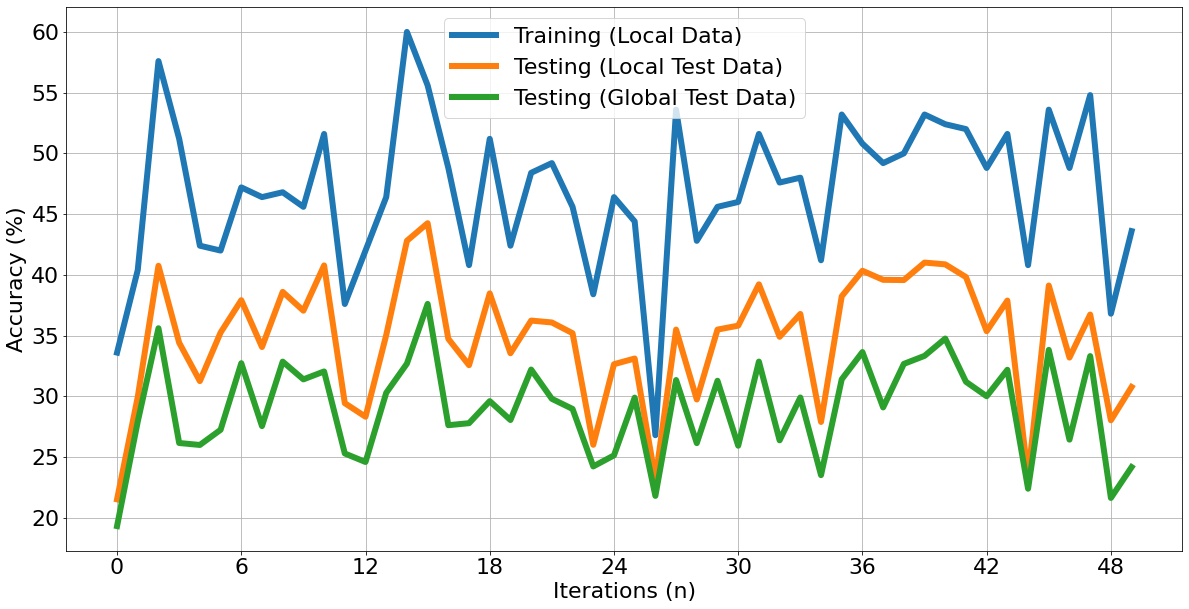

In [12]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_federated_learning).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))



In [13]:
len(training_round_accuracies_federated_learning)

50

## Federated Learning with Fine-Tuning

In [14]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
for item in range(10):
    models_collection['model_{}'.format(item)] = tf.keras.models.clone_model(model_global)
    


training_round = 50
training_round_accuracies_finetuned = []
train_sample_count= 25
for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in models_collection:
        models_collection[model].compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
        results = local_train(model=models_collection[model],
                        model_index=int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        '''
        Exteremely important to use "tf.keras.models.clone_model(results[0])" in the next
        line. Even copy.copy(results[0]) would produce a referenced model with the same weights/
        ''' 
        models_collection[model] = tf.keras.models.clone_model(results[0])
        
        print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_finetuned.append(models_accuracies)
    print('Averaging Models')
    
    if(iteration<10):
        model_global = average_models_weights(models_collection)
        print('total model layers', np.shape(model_global.layers))

        models_collection = {}
        for item in range(10):
            models_collection['model_{}'.format(item)] = model_global
    else:
        pass
    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
Starting iteration: 0
313/313 [==============================] - 2s 8ms/step - loss: 33.7584 - accuracy: 0.1128
Accuracies: Training=0.11999999731779099, Local Test=0.12275132536888123, Global Test=0.1128000020980835
model_0 -0.03981837
model_0 0.015556887
313/313 [==============================] - 2s 7ms/step - loss: 28.0029 - accuracy: 0.1508
Accuracies: Training=0.2800000011920929, Local Test=0.13699907064437866, Global Test=0.15080000460147858
model_1 -0.03981837
model_1 -0.05382605
313/313 [==============================] - 2s 6ms/step - loss: 32.4193 - accuracy: 0.0678
Accuracies: Training=0.1599999964237213, Local Test=0.08879919350147247, Global Test=0.06780000030994415
model_2 -0.03981837
model_2 -0.05382605
313/313 [==============================] - 2s 7ms/step - loss: 24.5443 - accuracy: 0.1135
Accuracies: Training=0.3199999928474426, Local Test=0.24144868552684784, Global Test=0.11349999904632568
model_3 -0.03981837
model_3 -0.05382605
313/313 [====

313/313 [==============================] - 2s 7ms/step - loss: 2.1477 - accuracy: 0.4434
Accuracies: Training=0.6399999856948853, Local Test=0.48818087577819824, Global Test=0.44339999556541443
model_6 -0.025060296
model_6 -0.033375543
313/313 [==============================] - 2s 7ms/step - loss: 2.0569 - accuracy: 0.4729
Accuracies: Training=0.6800000071525574, Local Test=0.4780915379524231, Global Test=0.47290000319480896
model_7 -0.025060296
model_7 -0.033375543
313/313 [==============================] - 2s 8ms/step - loss: 1.9867 - accuracy: 0.3927
Accuracies: Training=0.6800000071525574, Local Test=0.4866412281990051, Global Test=0.3926999866962433
model_8 -0.025060296
model_8 -0.033375543
313/313 [==============================] - 2s 7ms/step - loss: 1.8901 - accuracy: 0.3852
Accuracies: Training=0.6800000071525574, Local Test=0.486868679523468, Global Test=0.38519999384880066
model_9 -0.025060296
model_9 -0.033375543
Averaging Models
total model layers (10,)
Finieshed iteration

313/313 [==============================] - 2s 7ms/step - loss: 2.2543 - accuracy: 0.1050
Accuracies: Training=0.3199999928474426, Local Test=0.31483349204063416, Global Test=0.10499999672174454
model_2 -0.0780969
model_2 -0.08810528
313/313 [==============================] - 2s 7ms/step - loss: 2.2025 - accuracy: 0.3046
Accuracies: Training=0.47999998927116394, Local Test=0.25150904059410095, Global Test=0.3046000003814697
model_3 -0.0780969
model_3 -0.08810528
313/313 [==============================] - 2s 7ms/step - loss: 2.1693 - accuracy: 0.1386
Accuracies: Training=0.36000001430511475, Local Test=0.3143143057823181, Global Test=0.13860000669956207
model_4 -0.0780969
model_4 -0.08810528
313/313 [==============================] - 2s 7ms/step - loss: 2.1275 - accuracy: 0.3513
Accuracies: Training=0.5600000023841858, Local Test=0.4104166626930237, Global Test=0.3513000011444092
model_5 -0.0780969
model_5 -0.08810528
313/313 [==============================] - 2s 6ms/step - loss: 2.0876 

313/313 [==============================] - 2s 6ms/step - loss: 1.9260 - accuracy: 0.4203
Accuracies: Training=0.6399999856948853, Local Test=0.47979798913002014, Global Test=0.4203000068664551
model_9 0.031398796
model_9 -0.052167095
Averaging Models
total model layers (10,)
Finieshed iteration: 4
Starting iteration: 5
313/313 [==============================] - 2s 6ms/step - loss: 2.2764 - accuracy: 0.1991
Accuracies: Training=0.47999998927116394, Local Test=0.27407407760620117, Global Test=0.19910000264644623
model_0 0.06588128
model_0 -0.006504413
313/313 [==============================] - 2s 6ms/step - loss: 2.2634 - accuracy: 0.2062
Accuracies: Training=0.3199999928474426, Local Test=0.37837839126586914, Global Test=0.2062000036239624
model_1 0.06588128
model_1 0.030418262
313/313 [==============================] - 2s 7ms/step - loss: 2.2278 - accuracy: 0.2356
Accuracies: Training=0.4399999976158142, Local Test=0.3733602464199066, Global Test=0.23559999465942383
model_2 0.06588128


313/313 [==============================] - 2s 7ms/step - loss: 2.1211 - accuracy: 0.4025
Accuracies: Training=0.4399999976158142, Local Test=0.3125, Global Test=0.4025000035762787
model_5 -0.05382774
model_5 0.09061906
313/313 [==============================] - 2s 6ms/step - loss: 2.0767 - accuracy: 0.3432
Accuracies: Training=0.6000000238418579, Local Test=0.4316546618938446, Global Test=0.3431999981403351
model_6 -0.05382774
model_6 0.09061906
313/313 [==============================] - 3s 8ms/step - loss: 2.0093 - accuracy: 0.4736
Accuracies: Training=0.47999998927116394, Local Test=0.45764362812042236, Global Test=0.47360000014305115
model_7 -0.05382774
model_7 0.09061906
313/313 [==============================] - 2s 7ms/step - loss: 1.9681 - accuracy: 0.3636
Accuracies: Training=0.5600000023841858, Local Test=0.39026716351509094, Global Test=0.3635999858379364
model_8 -0.05382774
model_8 0.09061906
313/313 [==============================] - 2s 7ms/step - loss: 1.9091 - accuracy: 0.

model_1 -0.02252733
model_1 -0.022300608
313/313 [==============================] - 2s 7ms/step - loss: 2.2520 - accuracy: 0.1521
Accuracies: Training=0.2800000011920929, Local Test=0.10998991131782532, Global Test=0.15209999680519104
model_2 -0.02252733
model_2 -0.022300608
313/313 [==============================] - 2s 7ms/step - loss: 2.2290 - accuracy: 0.2829
Accuracies: Training=0.5600000023841858, Local Test=0.43963783979415894, Global Test=0.28290000557899475
model_3 -0.02252733
model_3 -0.022300608
313/313 [==============================] - 2s 7ms/step - loss: 2.1791 - accuracy: 0.3887
Accuracies: Training=0.6000000238418579, Local Test=0.5155155062675476, Global Test=0.388700008392334
model_4 -0.02252733
model_4 -0.022300608
313/313 [==============================] - 2s 7ms/step - loss: 2.1779 - accuracy: 0.2068
Accuracies: Training=0.5199999809265137, Local Test=0.3385416567325592, Global Test=0.20679999887943268
model_5 -0.02252733
model_5 -0.022300608
313/313 [==============

313/313 [==============================] - 3s 10ms/step - loss: 1.9182 - accuracy: 0.3554
Accuracies: Training=0.6399999856948853, Local Test=0.3320610821247101, Global Test=0.3553999960422516
model_8 0.050930113
model_8 -0.04497263
313/313 [==============================] - 3s 9ms/step - loss: 1.8597 - accuracy: 0.4342
Accuracies: Training=0.5199999809265137, Local Test=0.521212100982666, Global Test=0.4341999888420105
model_9 0.050930113
model_9 -0.04497263
Averaging Models
total model layers (10,)
Finieshed iteration: 9
Starting iteration: 10
313/313 [==============================] - 3s 10ms/step - loss: 2.2799 - accuracy: 0.1412
Accuracies: Training=0.3199999928474426, Local Test=0.13121692836284637, Global Test=0.1412000060081482
model_0 0.041667446
model_0 0.008844649
313/313 [==============================] - 3s 8ms/step - loss: 2.2726 - accuracy: 0.1885
Accuracies: Training=0.3199999928474426, Local Test=0.35787510871887207, Global Test=0.18850000202655792
model_1 0.041667446


KeyboardInterrupt: 

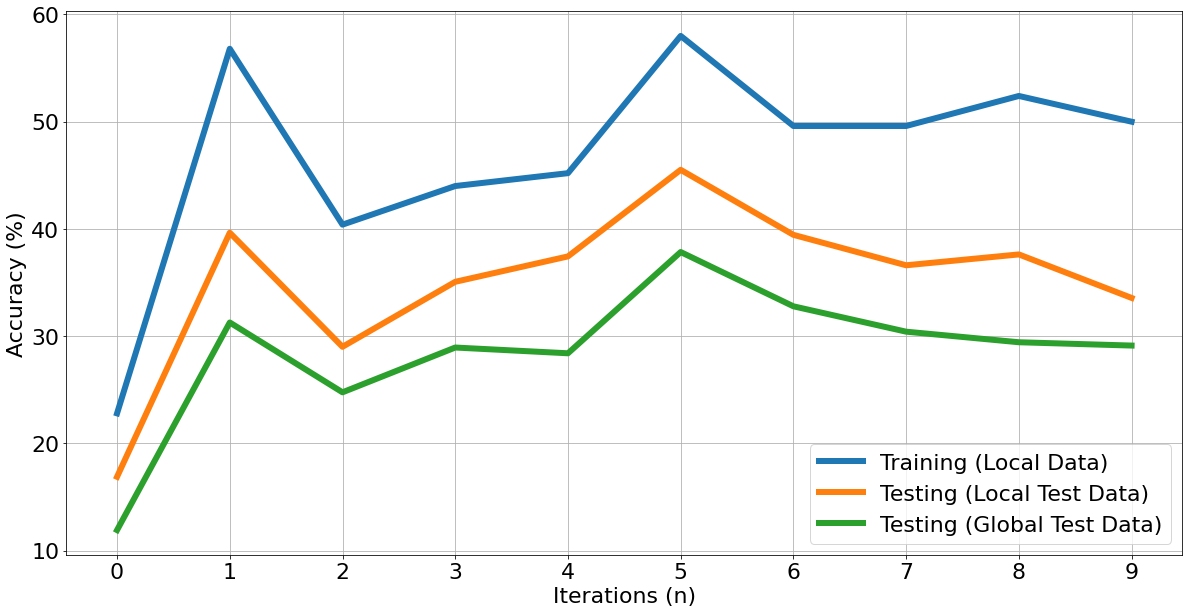

In [15]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_finetuned).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))

